# ECE 219 Project 1: End-to-End Pipeline to Classify News Articles

In [2]:
# import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allows matlab plots to be generated in line
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Getting familiar with the dataset

In [3]:
# read the csv file and get the shape
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project1-Classification.csv')

rows, columns = dataset.shape

print('Total number of rows: {0} and columns: {1}'.format(rows, columns))
dataset.head(3)

Total number of rows: 3150 and columns: 8


,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports


#### Plot histogram (a)

unique count on x axis: [   39    43    47 ... 47388 66189 80326]
the corresponding frequency on y axis: [ 1 13  1 ...  1  1  1]


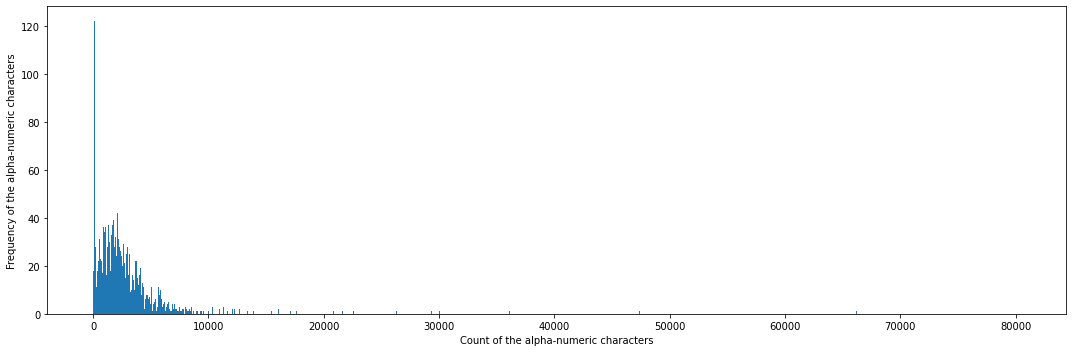

In [155]:
# define a function for finding all alpha-numeric characters
def find_alpha_numeric(text):
    """
    Args:
        text: a string of text
    Returns:
        result: a list of all alpha-numeric charactres
    """
    result = [i for i in text if i.isalpha() or i.isdigit()]
    
    return result


# iteratively get all total number for each row
num_alpha_numeric = np.array([len(find_alpha_numeric(each_text)) for each_text in dataset['full_text']])

# get the unique value of count and frequency of that count
unique, counts = np.unique(num_alpha_numeric, return_counts=True)
print('unique count on x axis: {}'.format(unique))
print('the corresponding frequency on y axis: {}'.format(counts))

# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.hist(num_alpha_numeric, bins=len(unique))
axes.set_xlabel("Count of the alpha-numeric characters")
axes.set_ylabel("Frequency of the alpha-numeric characters")
fig.tight_layout()

#### Plot histogram (b)

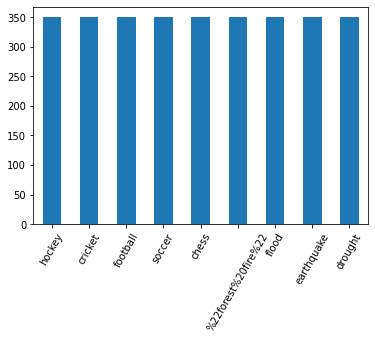

In [4]:
dataset['leaf_label'].value_counts().plot(kind='bar', rot=60)

#### Plot histogram (c)

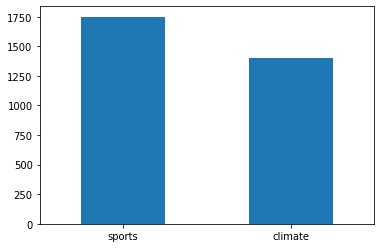

In [5]:
dataset['root_label'].value_counts().plot(kind='bar', rot=0)

<div class="alert alert-block alert-success">
<b>Question 1:</b> Provide answers to the following questions:
<ul>  
  <li><b>Overview:</b> How many rows (samples) and columns (features) are present in the dataset?</li>
  <li><b>Histograms</b> Plot 3 histograms on: </li>
    <ul>
      <li>(a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; </li>
      <li>(b) The column leaf label – class on the x-axis; </li>
      <li>(c) The column root label – class on the x-axis. </li>
    </ul>
   <li><b>Interpret Plots:</b> Provide qualitative interpretations of the histograms.</li>
</ul>
</div>


<div class="alert alert-block alert-success">
<b>Answer:</b> 
<ul>
  <li><b>Overview:</b> In total, there are 3150 samples and 8 features present in the dataset.</li>
  <li><b>Histograms:</b>
    <ul>
      <li> (a) as shown above</li>
      <li> (b) as shown above</li>
      <li> (c) as shown above</li>
    </ul>
  <li> <b>Interpret Plots:</b> According to the histogram (a), one can first observe a substantial inequality between each total number of alpha-numeric characters on the x-axis, ranging from only 39 to 80326. The frequency of each number is also unequally distributed, leading to a potential problem of bias towards certain class labels if we train the model based on alpha-numeric characters. Furthermore, histogram (b) shows an equal distribution between the 9 different lead labels with an amount of 350. Root label, on the other hand, offers an unequal distribution of 1750 and 1400 between sports and climate classes, respectively. This means that one has to be more careful about training based on root labels as there is a hidden bias towards sports class in the dataset.</li>
        
</ul>
</div>

## Binary Classification

For the first part of the project, we will be using only the **full text column** as the raw
features per sample (row) and the **root label column** as the label for each sample. The
root labels are well-separated.

In [5]:
import numpy as np
import random

# set up random seed
np.random.seed(42)
random.seed(42)

### 1. Splitting the entire dataset into training and testing data

In [7]:
from sklearn.model_selection import train_test_split

# extract only full_text and root_label columns and split into train and test
train, test = train_test_split(dataset[["full_text","root_label"]], test_size=0.2)

print("Number of training samples: {}".format(train.shape[0]))
print("Number of testing samples: {}".format(test.shape[0]))

Number of training samples: 2520
Number of testing samples: 630


<div class="alert alert-block alert-success">
<b>Question 2:</b> Report the number of training and testing samples.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> In total, there are 2520 training samples and 630 testing samples
</div>

### 2. Feature Extraction

In [6]:
import re

# function to clean the text
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
        
    return texter

<div class="alert alert-block alert-success">
Use the following specs to extract features from the textual data:
<ul>
  <li>Before doing anything, please clean each data sample using the code block provided above. This function helps remove many but not all HTML artefacts from the crawler’s output. You can also build your own cleaning module if you find this function to be ineffective.</li>
  <li>Use the “english” stopwords of the CountVectorizer</li>
  <li>Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)</li>
  <li>Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag</li>
  <li>Use min_df=3</li>
</ul>
</div>

In [9]:
# clean the full_text
train = train.applymap(clean)
test = test.applymap(clean)

#### Stemming

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation
import nltk

nltk.download('stopwords')

# define the whole process of stemming
def stemming(doc):
    """
    Args:
        doc: a string of text
    Returns:
        stemmed_words: a list of words (string)
    """
    # step 1: define tokenizer to tokenize the sentence into words (string)
    tokenizer = CountVectorizer().build_analyzer()
    
    # step 2: remove stopwords, punctuations, and numbers
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    words = [word for word in tokenizer(doc) 
             if word not in combined_stopwords and not word.isdigit()]
    
    # step 3: stem each word
    sno = nltk.stem.SnowballStemmer('english')  # or nltk.stem.PorterStemmer()
    stemmed_words = [sno.stem(word) for word in words]
    
    return stemmed_words


# step 4: train the CountVectorizer with lemmatizer as analyzer
stem_vectorizer = CountVectorizer(min_df=3, analyzer=stemming, stop_words='english')
X_train_stem = stem_vectorizer.fit_transform(train['full_text'])
X_test_stem = stem_vectorizer.transform(test['full_text'])

print(X_train_stem.toarray())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Lemmatization

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation
import nltk
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Converts Penn Treebank tags to WordNet
def penn2wn(penntag):
    wn_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return wn_tag[penntag[:2]]
    except:
        return 'n'

# define the whole process of lemmatization
def lemmatization(doc):
    """
    Args:
        doc: a string of text
    Returns:
        lemmatized_words: a list of words (string)
    """
    # step 1: define tokenizer to tokenize the sentence into words (string)
    tokenizer = CountVectorizer().build_analyzer()

    # step 2: assign word’s part-of-speech (POS) tag with pos_tag
    words_tags = pos_tag(tokenizer(doc))

    # step 3: convert Penn Treebank tags to WordNet with penn2wn
    words_tags = [(word, penn2wn(tag)) for word, tag in words_tags]
    
    # step 4: lemmatize each word based on converted part-of-speech tag
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatized_words = [wnl.lemmatize(word.lower(), pos=tag) for word, tag in words_tags]
    
    # step 5: remove stopwords, punctuations, and numbers
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    
    lemmatized_words = [word for word in lemmatized_words 
                        if word not in combined_stopwords and not word.isdigit()]
    
    return lemmatized_words


# step 6: train the CountVectorizer with lemmatizer as analyzer
lemma_vectorizer = CountVectorizer(min_df=3, analyzer=lemmatization, stop_words='english')
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

print(X_train_lemma.toarray())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Term Frequency-Inverse Document Frequency Model (TF-IDF)

In [12]:
# test different min_dfs for Q3-2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

min_dfs = range(1,5)
for min_df in min_dfs:
    
    # set up CountVectorizer
    exclude_nums = lambda x: re.sub(r'\d+', '', x)
    vectorizer = CountVectorizer(preprocessor=exclude_nums, 
                                 stop_words='english', min_df=min_df)

    # convert text documents to document-term matrix
    X_train_vec = vectorizer.fit_transform(train['full_text'])
    X_test_vec = vectorizer.transform(test['full_text'])

    # convert to TF-IDF matrix
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
    X_test_tfidf = tfidf_transformer.transform(X_test_vec)
    

    print(X_train_tfidf.shape)

(2520, 50592)
(2520, 28057)
(2520, 20338)
(2520, 16300)


In [13]:
# Report the shape of TF-IDF-processed matrix for Q3-4

# vectorizer with lemmatization
lemma_vectorizer = CountVectorizer(min_df=3, analyzer=lemmatization, stop_words='english')

# train the vectorizer, and convert text documents to document-term matrix
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_lemma)
X_test_tfidf = tfidf_transformer.transform(X_test_lemma)

print("Shape of TF-IDF-processed train matrix: {}".format(X_train_tfidf.shape))
print("Shape of TF-IDF-processed test matrix: {}".format(X_test_tfidf.shape))

Shape of TF-IDF-processed train matrix: (2520, 13715)
Shape of TF-IDF-processed test matrix: (630, 13715)


<div class="alert alert-block alert-success">
<b>Question 3:</b> Please answer the following questions:
<ul>
  <li>What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?</li>
  <li>min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?</li>
  <li>Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.</li>
  <li>Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.</li>
    
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>
<ul> 
  <li>Lemmatization has almost always higher accuracy than stemming as it is a canonical dictionary-based approach that performs an analysis depending on the word’s part-of-speech and produces actual dictionary words, whereas stemming is a rule-based approach that trims words regardless of the context. Moreover, lemmatization has the advantage of context awareness since it trims words context-dependently and is thus better for context analysis. However, lemmatization is more sophisticated, harder to implement, and slower compared to stemming. Overall, lemmatization will almost always generate a larger dictionary size based on its properties.</li>
  <li>The higher the "min_df" value is set, the fewer columns the TF-IDF matrix has, leading to the smaller matrix (same rows x smaller columns)</li>
  <li>Stopwords, Punctuations, and numbers should be removed after lemmatizing since they provide the context for the sentence. Removing them beforehand will cause the sentence to lose a certain meaning, which is critical in lemmatization as it should be context-dependently to yield better performance.</li>
  <li>The shape of the TF-IDF-processed train matrix is (2520, 13715) and the test matrix is (630, 13715)</li>
</ul>
</div>





### 3. Dimensionality Reduction

#### Latent Semantic Indexing (LSI) with different number of components

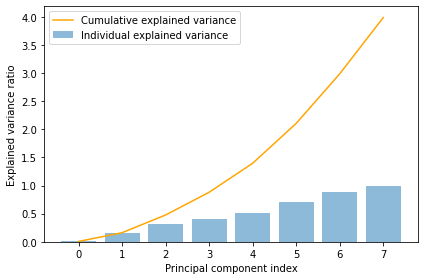

In [14]:
from sklearn.decomposition import TruncatedSVD

# Define the number of topics or components
n_components=[1, 10, 50, 100, 200, 500, 1000, 2000]
ExVar_ratios = []
ExVar_ratios_sum = []
sum_ratio = 0

for k in n_components:    
    # create SVD object for LSI
    lsi = TruncatedSVD(n_components=k, n_iter=5, random_state=42)

    # fit SVD model on with TF-IDF processed matrix
    X_train_lsi = lsi.fit_transform(X_train_tfidf)

    # # get singular values, right singular vectors, explained variance
    # Sigma = lsi.singular_values_ 
    # V_transpose = lsi.components_.T
    # ExVar = lsi.explained_variance_
    
    # store explained variance ratio for the plot
    ExVar_ratio = lsi.explained_variance_ratio_.sum()
    ExVar_ratios.append(ExVar_ratio)
    sum_ratio += ExVar_ratio
    ExVar_ratios_sum.append(sum_ratio)
    
    
plt.bar(range(0,len(ExVar_ratios)), ExVar_ratios, alpha=0.5, 
        align='center', label='Individual explained variance')
# plt.step(range(0,len(ExVar_ratios_sum)), ExVar_ratios_sum, 
#          where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(ExVar_ratios_sum)), ExVar_ratios_sum, 
         color='orange', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Latent Semantic Indexing (LSI) and Non-negative Matrix Factorization (NMF) with K = 50

In [113]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

# reduce to k features
k=50

# Latent Semantic Indexing (LSI)
lsi = TruncatedSVD(n_components=k, n_iter=5, random_state=42)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)
Sigma = lsi.singular_values_ 
V_transpose = lsi.components_.T

# calculate MSE loss of LSI
train_loss_lsi = np.sum(np.array(X_train_tfidf - np.matmul(X_train_lsi, V_transpose.T))**2)
test_loss_lsi = np.sum(np.array(X_test_tfidf - np.matmul(X_test_lsi, V_transpose.T))**2)

# Non-negative Matrix Factorization (NMF)
nmf = NMF(n_components=k, init='random', random_state=42)
W_nmf = nmf.fit_transform(X_train_tfidf)
W_nmf_test = nmf.transform(X_test_tfidf)
H_nmf = nmf.components_

# calculate MSE loss of NMF
train_loss_nmf = np.sum(np.array(X_train_tfidf - np.matmul(W_nmf, H_nmf))**2)
test_loss_nmf = np.sum(np.array(X_test_tfidf - np.matmul(W_nmf_test, H_nmf))**2)


print('The MSE loss of training set in LSI is {}'.format(train_loss_lsi))
print('The MSE loss of testing set in LSI is {}'.format(test_loss_lsi))
print('The MSE loss of training set in NMF is {}'.format(train_loss_nmf))
print('The MSE loss of testing set in NMF is {}'.format(test_loss_nmf))

The MSE loss of training set in LSI is 1670.6571084153147
The MSE loss of testing set in LSI is 444.207301657836
The MSE loss of training set in NMF is 1697.8966418578825
The MSE loss of testing set in NMF is 452.0613550888077


<div class="alert alert-block alert-success">
<b>QUESTION 4:</b> Reduce the dimensionality of the data using the methods above:
<ul>    
  <li>Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?</li>
  <li>With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $∥X −WH∥^2_F$ in NMF or the $∥X −U_k\Sigma_kV^T_k∥^2_F$ in LSI and why?</li>
</ul>    
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>
<ul> 
  <li>As shown above, the explained variance ratio plot looks like an exponential function. Based on the concavity, we could tell that the more features we keep (higher k value), the more representative the transformed matrix is with respect to the original matrix, and it grows not linearly but exponentially.</li>
  <li>The MSE loss in NMF is larger in both the training and testing dataset because NMF usually works better with shorter texts, whereas LSI is better with longer texts, and most of our texts here are pretty long. Moreover, NMF fails to consider the context in the text, and thus, it is obvious that NMF leads to a larger loss compared with LSI when the feature dimension is so largely reduced (only 4% left).</li>
</ul>
</div>

### 4. Classification Algorithms

In this part, you are asked to use the dimensionality-reduced training data from LSI with your choice of k to train (different types of) classifiers, and evaluate the 6 trained classifiers with test data. Your task would be to classify the documents into two classes (for now a binary classification task) sports versus climate.

In [24]:
# create several useful functions

from sklearn import metrics

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()
    
    roc_auc = metrics.auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

        
def standard_confusion_matrix(gt, pred):
    """
    Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    """
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(np.asarray(gt), np.asarray(pred))
    
    return np.array([[tp, fp], [fn, tn]])


def evaluation_scores(gt, pred):
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(np.asarray(gt), np.asarray(pred))
    # accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    # Precision, Recall, F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    # # TPR(sensitivity), TNR(specificity)
    # tpr = tp / (tp + fn)
    # tnr = tn / (tn + fp)
    
    return accuracy, precision, recall, f1_score


def print_cm(cm):
    print(f'  - Confusion Matrix:\n'
          '    -----------------------\n'
          f'    | TP: {cm[0,0]:4.0f} | FP: {cm[0,1]:4.0f} |\n'
          '    -----------------------\n'
          f'    | FN: {cm[1,0]:4.0f} | TN: {cm[1,1]:4.0f} |\n'
          '    -----------------------')
    
def print_scores(accuracy, precision, recall, f1_score):
    print('- Classification:\n'
          '    Accuracy: {0:5.2f}%\n'
          '    Precision: {1:6.4f}\n'
          '    Recall: {2:6.4f}\n'
          '    F1-score: {3:6.4f}'.format(accuracy*100, precision,
                                          recall, f1_score))

In [114]:
from sklearn.decomposition import TruncatedSVD

# convert GT class labels to numbers {'climate': 0, 'sports': 1}
labels_dict = dict(zip(train['root_label'].unique(), 
                       range(0,train['root_label'].unique().size)))
Y_train = train['root_label'].map(labels_dict, na_action='ignore')
Y_test = test['root_label'].map(labels_dict, na_action='ignore')

# choose specific k
k = 1000

# create SVD object for LSI and train + transform
lsi = TruncatedSVD(n_components=k, n_iter=5, random_state=42)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

#### Support Vector Machines (SVM) with $\gamma = 1000$ (hard margin) 

- Classification:
    Accuracy: 97.14%    Precision: 0.9861
    Recall: 0.9646
    F1-score: 0.9752
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  354 | FP:    5 |
    -----------------------
    | FN:   13 | TN:  258 |
    -----------------------
--------------------


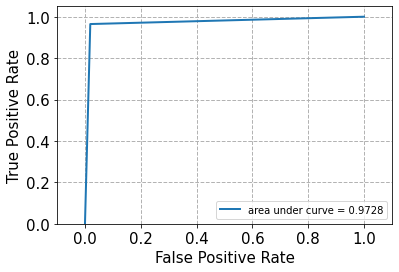

In [18]:
from sklearn.svm import SVC

# SVM with hard margin
svm_hard = SVC(C=1000, kernel='linear', probability=True, random_state=42)
svm_hard = svm_hard.fit(X_train_lsi, Y_train)
svm_hard_pred = svm_hard.predict(X_test_lsi)
svm_hard_pred_prob = svm_hard.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_hard_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, svm_hard_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_hard_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

#### Support Vector Machines (SVM) with $\gamma = 0.0001$ (soft margin) 

- Classification:
    Accuracy: 58.25%    Precision: 0.5825
    Recall: 1.0000
    F1-score: 0.7362
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  367 | FP:  263 |
    -----------------------
    | FN:    0 | TN:    0 |
    -----------------------
--------------------


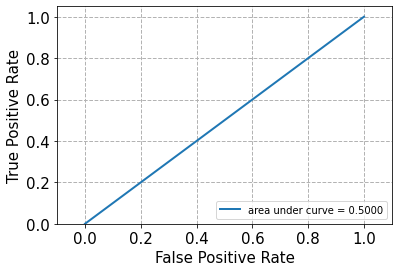

In [19]:
from sklearn.svm import SVC

# SVM with soft margin
svm_soft = SVC(C=0.0001, kernel='linear', probability=True, random_state=42)
svm_soft = svm_soft.fit(X_train_lsi, Y_train)
svm_soft_pred = svm_soft.predict(X_test_lsi)
svm_soft_pred_prob = svm_soft.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_soft_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, svm_soft_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_soft_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

#### Support Vector Machines (SVM) with $\gamma = 100000$ (hard margin) 

- Classification:
    Accuracy: 97.14%    Precision: 0.9861
    Recall: 0.9646
    F1-score: 0.9752
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  354 | FP:    5 |
    -----------------------
    | FN:   13 | TN:  258 |
    -----------------------
--------------------


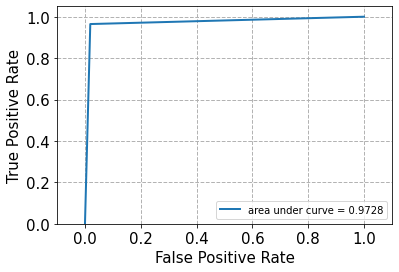

In [20]:
from sklearn.svm import SVC

# SVM with hard margin
svm_hard = SVC(C=100000, kernel='linear', probability=True, random_state=42)
svm_hard = svm_hard.fit(X_train_lsi, Y_train)
svm_hard_pred = svm_hard.predict(X_test_lsi)
svm_hard_pred_prob = svm_hard.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_hard_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, svm_hard_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_hard_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

#### Use 5-fold cross-validation to choose $\gamma$ in range $\{10^k| − 3 ≤ k ≤6, k \in \mathbb{Z}\}$ for SVM

The best gamma is 1 with the 95.48% accuracy
- Classification:
    Accuracy: 96.67%    Precision: 0.9832
    Recall: 0.9591
    F1-score: 0.9710
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  352 | FP:    6 |
    -----------------------
    | FN:   15 | TN:  257 |
    -----------------------
--------------------


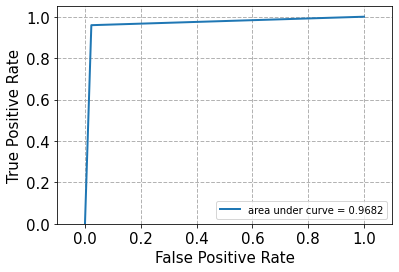

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.svm import SVC

best_score = 0
scores_list = []

# find best gamma
for k in range(-3, 6+1):
    
    # SVM model
    gamma = 10**k
    svm = SVC(C=gamma, kernel='linear', probability=True, random_state=42)

    # k-fold cross-validation 
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(svm, X_train_lsi, Y_train , cv=cv, scoring='accuracy')
    
    cur_score = scores.mean()
    scores_list.append(cur_score)

    if cur_score > best_score:
        best_score = cur_score
        best_gamma = gamma

print('The best gamma is {} with the {:5.2f}% accuracy'.format(best_gamma, best_score*100))

# SVM with best gamma
svm_hard = SVC(C=best_gamma, kernel='linear', probability=True, random_state=42)
svm_hard = svm_hard.fit(X_train_lsi, Y_train)
svm_hard_pred = svm_hard.predict(X_test_lsi)
svm_hard_pred_prob = svm_hard.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_hard_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, svm_hard_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_hard_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

<div class="alert alert-block alert-success">
<b>QUESTION 5:</b> Compare and contrast hard-margin and soft-margin linear SVMs:
<ul> 
  <li><b>Train two linear SVMs:</b></li>
    <ul>
      <li>Train one SVM with $\gamma$ = 1000 (hard margin), another with $\gamma$ = 0.0001 (soft margin).</li>
      <li>Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for $\gamma$ = 100000?</li>
      <li>What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.</li>
      <li>Does the ROC curve reflect the performance of the soft-margin SVM? Why?</li>
    </ul>
  <li><b>Use cross-validation to choose $\gamma$ (use average validation 3 accuracy to compare):</b> Using a 5-fold cross-validation, find the best value of the parameter $\gamma$ in the range $\{10^k| − 3 ≤ k ≤6, k \in \mathbb{Z}\}$. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.</li>
</ul>
</div>



<div class="alert alert-block alert-success">
<b>Answer:</b>
<ul>
  <li><b>Train two linear SVMs:</b></li>
    <ul>
      <li> The results of the trained SVMs with hard and soft margins are shown above.</li>
      <li> The plots as well as the reports of the confusion matrix and each classification score are shown above under each section. The SVM with a hard margin ($\gamma=1000$) yields better performance compared with SVM with a soft margin in this case with higher accuracy, F-1 score, area under ROC curve, etc. As for the SVM with hard margin ($\gamma=100000$), a similar result at each classification score in respect of $\gamma=1000$ is achieved, meaning that the global minimum is probably arrived with $\gamma=1000$ and thus, increasing the value of $\gamma$ doesn't improve the SVM model performance. </li>
      <li> Based on the confusion matrix of SVM with soft margin, one can realize that the model isn't well trained at all since it only predicts one class as result regardless of which input data points, meaning that the model allows a lot of misclassification during the training. This happens because, with such a low penalty (low value of $\gamma$), the classifier is algorithmically allowed to misclassify lots of points to maximize the margin. Therefore, we can say that the SVM with a soft margin will lead to a random classifier.</li>
      <li> Yes, the ROC curve also reflects the worse performance of the soft-margin SVM. Since the ROC curve is a straight line and has an area under the curve of 0.5, it is expected that the soft-margin SVM is like a random classifier.</li>
    </ul>
  <li><b>Use cross-validation to choose $\gamma$:</b> The best value of the parameter $\gamma$ is equal to 1. The implementation, the plot, and the report of the classification scores are all shown above. </li>
</ul>
</div>

#### Logistic Regression (LR) without regularization

- Classification:
    Accuracy: 96.98%    Precision: 0.9915
    Recall: 0.9564
    F1-score: 0.9736
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  351 | FP:    3 |
    -----------------------
    | FN:   16 | TN:  260 |
    -----------------------
--------------------


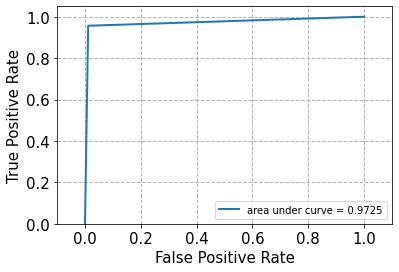

In [22]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression model without regularization
LR_noreg = LogisticRegression(penalty='none')
LR_noreg = LR_noreg.fit(X_train_lsi, Y_train)
LR_noreg_pred = LR_noreg.predict(X_test_lsi)
LR_noreg_pred_prob = LR_noreg.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, LR_noreg_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, LR_noreg_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, LR_noreg_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)


#### Logistic Regression (LR) with L1 regularization and 5-fold cross-validation

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The best gamma is 1 with the 95.48% accuracy
- Classification:
    Accuracy: 95.71%    Precision: 0.9749
    Recall: 0.9510
    F1-score: 0.9628
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  349 | FP:    9 |
    -----------------------
    | FN:   18 | TN:  254 |
    -----------------------
--------------------


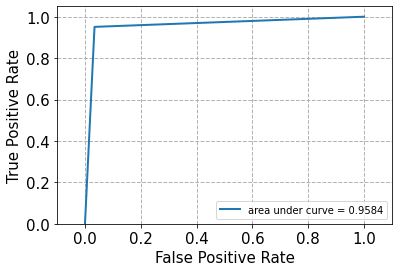

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold

best_score = 0
scores_list = []

# find best gamma
for k in range(-5, 5+1):
    
    # SVM model
    gamma = 10**k
    LR_l1 = LogisticRegression(penalty='l1', C=gamma, solver='liblinear')

    # k-fold cross-validation 
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(LR_l1, X_train_lsi, Y_train , cv=cv, scoring='accuracy')
    
    cur_score = scores.mean()
    scores_list.append(cur_score)

    if cur_score > best_score:
        best_score = cur_score
        best_gamma = gamma

print('The best gamma is {} with the {:5.2f}% accuracy'.format(best_gamma, best_score*100))

# SVM with best gamma
LR_l1 = LogisticRegression(penalty='l1', C=best_gamma, solver='liblinear')
LR_l1 = LR_l1.fit(X_train_lsi, Y_train)
LR_l1_pred = LR_l1.predict(X_test_lsi)
LR_l1_pred_prob = LR_l1.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, LR_l1_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, LR_l1_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, LR_l1_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

#### Logistic Regression (LR) with L2 regularization and 5-fold cross-validation

- Classification:
    Accuracy: 95.40%    Precision: 0.9509
    Recall: 0.9476
    F1-score: 0.9492
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  271 | FP:   14 |
    -----------------------
    | FN:   15 | TN:  330 |
    -----------------------
--------------------


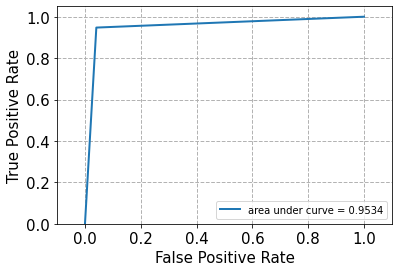

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold

best_score = 0
scores_list = []

# find best gamma
for k in range(-5, 5+1):
    
    # SVM model
    gamma = 10**k
    LR_l2 = LogisticRegression(penalty='l2', C=gamma)

    # k-fold cross-validation 
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(LR_l2, X_train_lsi, Y_train , cv=cv, scoring='accuracy')
    
    cur_score = scores.mean()
    scores_list.append(cur_score)

    if cur_score > best_score:
        best_score = cur_score
        best_gamma = gamma

print('The best gamma is {} with the {:5.2f}% accuracy'.format(best_gamma, best_score*100))

# SVM with best gamma
LR_l2 = LogisticRegression(penalty='l2', C=best_gamma)
LR_l2 = LR_l2.fit(X_train_lsi, Y_train)
LR_l2_pred = LR_l2.predict(X_test_lsi)
LR_l2_pred_prob = LR_l2.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, LR_l2_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, LR_l2_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, LR_l2_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

<div class="alert alert-block alert-success">
<b>QUESTION 6:</b> Evaluate a logistic classifier:
<ul>
  <li>Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.</li>
  <li><b>Find the optimal regularization coefficient:</b></li>
    <ul>
      <li>Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range $\{10^k| −5 ≤ k ≤ 5, k \in \mathbb{Z}\}$ for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.</li>
      <li>Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.</li>
      <li>How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?</li>
      <li>Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?</li>
    </ul>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>
<ul>   
  <li>The result, the plot, and the classification scores are all shown above. To avoid the utilization of regularization, the penalty is set to "None" in the sklearn.linear model.LogisticRegression model (penalty='none')</li>
  <li><b>Find the optimal regularization coefficient:</b></li>
    <ul>
      <li>Based on the 5-fold cross-validation shown above, the best regularization strength $\gamma$ is equal to 1 for both logistic regression with L1 regularization and logistic regression with L2 regularization.</li>
      <li>Overall, the logistic classifier without regularization yields slightly better performance compared with the other two with the highest accuracy and AUC value.</li>
      <li>By adding the regularization term, there is a chance that the test error will reduce due to the reduction of the variance of the model. However, in my case, the test error slightly increases in both regularized classifiers and thus the accuracy goes down a little bit. For L1 regularization, it helps to handle the sparsity of the learned coefficients, meaning that it decreases the less important feature’s coefficient to zero and inherently performs feature selection. L2 regularization, on the other hand, provides the ability to avoid overfitting. it adds a penalty to the excessive fluctuation of the learned coefficients and forces weights toward zero.</li>
      <li>SVM tries to find the best boundary that maximizes the margin to separate the data points into each class. Logistic regression, on the other hand, tries to optimize the output probability of each data point to each class, depending on the sum of the inputs and parameters. It can have different decision boundaries with different weights that might be near the optimal point. Therefore, based on the different characteristics of each algorithm, they have different performances. This difference can either be statistically important or unimportant, depending on the complexity of the data. SVM performs well on unstructured data and logistic regression works better with easily structured data. Therefore, the more complex the data structure is, the better performance the SVM model can potentially have compared with the logistic regression model. </li>
    </ul>
</ul>
</div>

#### Na¨ıve Bayes Model

- Classification:
    Accuracy: 80.63%    Precision: 0.7995
    Recall: 0.8910
    F1-score: 0.8428
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  327 | FP:   82 |
    -----------------------
    | FN:   40 | TN:  181 |
    -----------------------
--------------------


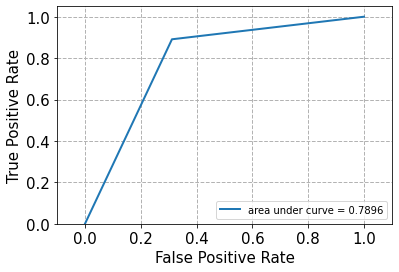

In [25]:
from sklearn.naive_bayes import GaussianNB

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_lsi, Y_train)
gnb_pred = gnb.predict(X_test_lsi)
gnb_pred_prob = gnb.predict_proba(X_test_lsi)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, gnb_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, gnb_pred)

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)


<div class="alert alert-block alert-success">
<b>Question 7:</b> Evaluate and profile a Na¨ıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> The result of the trained Na¨ıve Bayes classifier is shown above, along with all classification scores and confusion matrix.
</div>


## Grid Search of Parameters

In [40]:
from sklearn.model_selection import train_test_split

# extract only full_text and leaf_label columns and split into train and test
train, test = train_test_split(dataset[["full_text","root_label"]], test_size=0.2)

# clean the full_text
train = train.applymap(clean)
test = test.applymap(clean)

In [41]:
# basic
import numpy as np
import matplotlib.pyplot as plt
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# dimensionality reduction
from sklearn.decomposition import TruncatedSVD, NMF
# model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# grid seach related
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [47]:
# get the input data
train, test = train_test_split(dataset[["full_text", "root_label"]], test_size=0.2)

# clean data
train = train.applymap(clean)
test = test.applymap(clean)

# set up pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42)),
    ('clf', SVC()),
])

# best gamma previously found
svm_best_gamma = 1
lr_l1_best_gamma = 1
lr_l2_best_gamma = 1

# parameters
MIN_DIF = [3, 5]
ANALYSER = [lemmatization, stemming]
REDUCE_DIM_MODELS = [TruncatedSVD(random_state=42), NMF(random_state=42)]
N_FEATURES_OPTIONS = [5, 30, 80]
LR_MODELS = [LogisticRegression(penalty='l1', C=lr_l1_best_gamma, solver='liblinear'),
             LogisticRegression(penalty='l2', C=lr_l2_best_gamma, solver='liblinear')]

param_grid = [
    {
        'vect__min_df': MIN_DIF,                        # 2 choices
        'vect__analyzer': ANALYSER,                     # 2 choices
        'reduce_dim': REDUCE_DIM_MODELS,                # 2 choices
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
        'clf': [SVC(C=svm_best_gamma, kernel='linear', 
                    probability=True, random_state=42)],
        # 24 choices
    },
    {
        'vect__min_df': MIN_DIF,                        # 2 choices
        'vect__analyzer': ANALYSER,                     # 2 choices
        'reduce_dim': REDUCE_DIM_MODELS,                # 2 choices
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
        'clf': LR_MODELS,                               # 2 choices
        # 48 choices
    },
    {
        'vect__min_df': MIN_DIF,                        # 2 choices
        'vect__analyzer': ANALYSER,                     # 2 choices
        'reduce_dim': REDUCE_DIM_MODELS,                # 2 choices
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
        'clf': [GaussianNB()],
        # 24
    },
    # 24 + 48 + 24 = 96 choices in total
]

In [78]:
# start grid search
num_folds = 5
grid = GridSearchCV(pipeline, param_grid=param_grid, 
                    scoring='accuracy', n_jobs=1, cv=num_folds)
grid.fit(train['full_text'], train['root_label'])

In [ ]:
# import joblib
# # save grid search results
# joblib.dump(grid, '/content/drive/MyDrive/Colab Notebooks/grid_search_result.pkl')

# # load grid search results for further usage
# joblib.load('/content/drive/MyDrive/Colab Notebooks/grid_search_result.pkl')

##### Print out the setting of the best 5 models from Grid Search

In [85]:
# get the highest 5 mean test scores on validation
best_scores = np.sort(grid.cv_results_['mean_test_score'])[::-1][:5]
print('The highest 5 mean test scores on validation are: {}'.format(best_scores))

# get the corresponding indices
best_scores_idx = np.argsort(grid.cv_results_['mean_test_score'])[::-1][:5]

# print the 5 best combinations
print('The corresponding 5 best combinations are:')
for i in best_scores_idx:
    print(grid.cv_results_['params'][i])

The highest 5 mean test scores on validation are: [0.95833333 0.95793651 0.95714286 0.95674603 0.95436508]
The corresponding 5 best combinations are:
{'clf': GaussianNB(), 'reduce_dim': NMF(n_components=80, random_state=42), 'reduce_dim__n_components': 80, 'vect__analyzer': <function lemmatization at 0x7f46ee9568b0>, 'vect__min_df': 5}
{'clf': GaussianNB(), 'reduce_dim': NMF(n_components=80, random_state=42), 'reduce_dim__n_components': 80, 'vect__analyzer': <function lemmatization at 0x7f46ee9568b0>, 'vect__min_df': 3}
{'clf': GaussianNB(), 'reduce_dim': NMF(n_components=80, random_state=42), 'reduce_dim__n_components': 80, 'vect__analyzer': <function stemming at 0x7f46ee9560d0>, 'vect__min_df': 3}
{'clf': GaussianNB(), 'reduce_dim': NMF(n_components=80, random_state=42), 'reduce_dim__n_components': 80, 'vect__analyzer': <function stemming at 0x7f46ee9560d0>, 'vect__min_df': 5}
{'clf': GaussianNB(), 'reduce_dim': NMF(n_components=80, random_state=42), 'reduce_dim__n_components': 30, '

<div class="alert alert-block alert-success">
<b>Question 8:</b> In this part, you will attempt to find the best model for binary classification.
<ul>
  <li>Construct a Pipeline that performs feature extraction, dimensionality reduction and classification.</li>
  <li>The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).</li>
  <li>In addition to any other hyperparameters you choose, your gridsearch must at least include: (see Table 1 in the project PDF)</li>
  <li>What are the 5 best combinations? Report their performances on the testing set.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> The 5 best combinations as well as each report and performance are demonstrated below. 
</div>


#### Report the performances of the 5 best models on the testing set

##### The best combination:
  
    {'clf': GaussianNB(), 
     'reduce_dim': NMF(n_components=80, random_state=42),
     'reduce_dim__n_components': 80, 
     'vect__analyzer': <function lemmatization at 0x7f46ee9568b0>,
     'vect__min_df': 5}

In [97]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

# lemmatization for vectorizer and min_df = 5
lemma_vectorizer = CountVectorizer(min_df=5, analyzer=lemmatization, stop_words='english')
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_lemma)
X_test_tfidf = tfidf_transformer.transform(X_test_lemma)

# NMF for dimension reduction with n_components = 80
nmf = NMF(n_components=80, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_nmf, train['root_label'])
gnb_pred = gnb.predict(X_test_nmf)
# evaluate
cm = standard_confusion_matrix(test['root_label'], gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(test['root_label'], gnb_pred)

# report
print('The performance of the best combination:\n')
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)

The performance of the best combination:

- Classification:
    Accuracy: 96.19%    Precision: 0.9878
    Recall: 0.9419
    F1-score: 0.9643
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  324 | FP:    4 |
    -----------------------
    | FN:   20 | TN:  282 |
    -----------------------
--------------------


##### The second best combination:

    {'clf': GaussianNB(), 
     'reduce_dim': NMF(n_components=80, random_state=42),
     'reduce_dim__n_components': 80, 
     'vect__analyzer': <function lemmatization at 0x7f46ee9568b0>, 
     'vect__min_df': 3}

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

# lemmatization for vectorizer and min_df = 3
lemma_vectorizer = CountVectorizer(min_df=3, analyzer=lemmatization, stop_words='english')
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_lemma)
X_test_tfidf = tfidf_transformer.transform(X_test_lemma)

# NMF for dimension reduction with n_components = 80
nmf = NMF(n_components=80, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_nmf, train['root_label'])
gnb_pred = gnb.predict(X_test_nmf)
# evaluate
cm = standard_confusion_matrix(test['root_label'], gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(test['root_label'], gnb_pred)

# report
print('The performance of the second best combination:\n')
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)

The performance of the second best combination:

- Classification:
    Accuracy: 96.35%    Precision: 0.9878
    Recall: 0.9448
    F1-score: 0.9658
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  325 | FP:    4 |
    -----------------------
    | FN:   19 | TN:  282 |
    -----------------------
--------------------


##### The third best combination:

    {'clf': GaussianNB(), 
     'reduce_dim': NMF(n_components=80, random_state=42),
     'reduce_dim__n_components': 80, 
     'vect__analyzer': <function stemming at 0x7f46ee9560d0>, 
     'vect__min_df': 3}


In [106]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

# stemming for vectorizer and min_df = 3
stem_vectorizer = CountVectorizer(min_df=3, analyzer=stemming, stop_words='english')
X_train_stem = stem_vectorizer.fit_transform(train['full_text'])
X_test_stem = stem_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_stem)
X_test_tfidf = tfidf_transformer.transform(X_test_stem)

# NMF for dimension reduction with n_components = 80
nmf = NMF(n_components=80, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_nmf, train['root_label'])
gnb_pred = gnb.predict(X_test_nmf)
# evaluate
cm = standard_confusion_matrix(test['root_label'], gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(test['root_label'], gnb_pred)

# report
print('The performance of the third best combination:\n')
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)

The performance of the third best combination:

- Classification:
    Accuracy: 96.03%    Precision: 0.9848
    Recall: 0.9419
    F1-score: 0.9629
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  324 | FP:    5 |
    -----------------------
    | FN:   20 | TN:  281 |
    -----------------------
--------------------


##### The fourth best combination:

    {'clf': GaussianNB(), 
     'reduce_dim': NMF(n_components=80, random_state=42),
     'reduce_dim__n_components': 80,
     'vect__analyzer': <function stemming at 0x7f46ee9560d0>,
     'vect__min_df': 5}


In [102]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

# stemming for vectorizer and min_df = 5
stem_vectorizer = CountVectorizer(min_df=5, analyzer=stemming, stop_words='english')
X_train_stem = stem_vectorizer.fit_transform(train['full_text'])
X_test_stem = stem_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_stem)
X_test_tfidf = tfidf_transformer.transform(X_test_stem)

# NMF for dimension reduction with n_components = 80
nmf = NMF(n_components=80, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_nmf, train['root_label'])
gnb_pred = gnb.predict(X_test_nmf)
# evaluate
cm = standard_confusion_matrix(test['root_label'], gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(test['root_label'], gnb_pred)

# report
print('The performance of the fourth best combination:\n')
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)

The performance of the fourth best combination:

- Classification:
    Accuracy: 96.19%    Precision: 0.9848
    Recall: 0.9448
    F1-score: 0.9644
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  325 | FP:    5 |
    -----------------------
    | FN:   19 | TN:  281 |
    -----------------------
--------------------


##### The fifth best combination:

    {'clf': GaussianNB(), 
     'reduce_dim': NMF(n_components=80, random_state=42),
     'reduce_dim__n_components': 30,
     'vect__analyzer': <function lemmatization at 0x7f46ee9568b0>,
     'vect__min_df': 5}

In [104]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

# lemmatization for vectorizer and min_df = 5
lemma_vectorizer = CountVectorizer(min_df=5, analyzer=lemmatization, stop_words='english')
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_lemma)
X_test_tfidf = tfidf_transformer.transform(X_test_lemma)

# NMF for dimension reduction with n_components = 30
nmf = NMF(n_components=30, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
X_test_nmf = nmf.transform(X_test_tfidf)

# Na¨ıve Bayes Model
gnb = GaussianNB()
gnb = gnb.fit(X_train_nmf, train['root_label'])
gnb_pred = gnb.predict(X_test_nmf)
# evaluate
cm = standard_confusion_matrix(test['root_label'], gnb_pred)
accuracy, precision, recall, f1_score = evaluation_scores(test['root_label'], gnb_pred)

# report
print('The performance of the fifth best combination:\n')
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)

The performance of the fifth best combination:

- Classification:
    Accuracy: 95.56%    Precision: 0.9877
    Recall: 0.9302
    F1-score: 0.9581
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  320 | FP:    4 |
    -----------------------
    | FN:   24 | TN:  282 |
    -----------------------
--------------------


## Multiclass Classification

We have so far been dealing with classifying the data points into two classes. In this part, we explore multiclass classification techniques through different algorithms. You will need to use the column of labels marked **leaf_label** for this section.

In [26]:
from sklearn.model_selection import train_test_split

# extract only full_text and leaf_label columns and split into train and test
train, test = train_test_split(dataset[["full_text","leaf_label"]], test_size=0.2)
print("Number of training samples: {}".format(train.shape[0]))
print("Number of testing samples: {}".format(test.shape[0]))

# clean the full_text
train = train.applymap(clean)
test = test.applymap(clean)

# convert GT class labels to numbers
'''
{0:"chess", 1:"cricket", 2:"hockey", 3:"soccer", 4:"football", 
 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake", 8:"drought"}
'''
num_classes = len(labels_dict)
labels_dict = {"chess": 0, "cricket": 1, "hockey": 2, "soccer": 3, "football": 4,
               "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7, "drought": 8}
Y_train = train['leaf_label'].map(labels_dict, na_action='ignore')
Y_test = test['leaf_label'].map(labels_dict, na_action='ignore')


Number of training samples: 2520
Number of testing samples: 630


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# vectorizer with lemmatization
lemma_vectorizer = CountVectorizer(min_df=3, analyzer=lemmatization, stop_words='english')

# train the vectorizer, and convert text documents to document-term matrix
X_train_lemma = lemma_vectorizer.fit_transform(train['full_text'])
X_test_lemma = lemma_vectorizer.transform(test['full_text'])

# convert to TF-IDF matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_lemma)
X_test_tfidf = tfidf_transformer.transform(X_test_lemma)

# create SVD object for LSI and train + transform with specific k
k = 1000
lsi = TruncatedSVD(n_components=k, n_iter=5, random_state=42)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

#### Na¨ıve Bayes multiclass classification


Classification Report

                     precision    recall  f1-score   support

              chess       0.48      0.42      0.45        71
            cricket       0.61      0.17      0.27        63
             hockey       0.19      0.10      0.13        80
             soccer       0.14      0.56      0.22        84
           football       0.14      0.12      0.13        65
%22forest%20fire%22       0.71      0.09      0.16        56
              flood       0.55      0.24      0.33        76
         earthquake       0.84      0.48      0.61        65
            drought       0.92      0.47      0.62        70

           accuracy                           0.30       630
          macro avg       0.51      0.29      0.33       630
       weighted avg       0.49      0.30      0.32       630



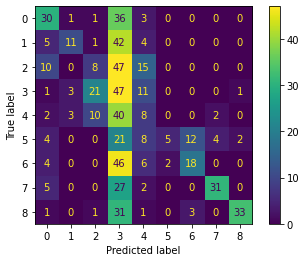

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Logistic Regression model without regularization
gnb = GaussianNB()
gnb = gnb.fit(X_train_lsi, Y_train)
gnb_pred = gnb.predict(X_test_lsi)

# report
print('\nClassification Report\n')
print(classification_report(Y_test, gnb_pred, target_names=list(labels_dict.keys())))

cm = confusion_matrix(Y_test, gnb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=gnb.classes_)
disp.plot()
plt.show()

#### SVM multiclass classification (One VS One) with class weight balance

- class_weight: 
  
  dict or ‘balanced’, default=None
Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))


Classification Report

                     precision    recall  f1-score   support

              chess       0.92      0.93      0.92        71
            cricket       0.97      0.94      0.95        63
             hockey       0.95      0.90      0.92        80
             soccer       0.30      0.30      0.30        84
           football       0.06      0.06      0.06        65
%22forest%20fire%22       0.69      0.91      0.78        56
              flood       0.97      0.93      0.95        76
         earthquake       0.97      0.86      0.91        65
            drought       0.91      0.90      0.91        70

           accuracy                           0.74       630
          macro avg       0.75      0.75      0.75       630
       weighted avg       0.75      0.74      0.74       630



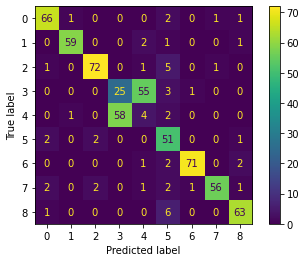

In [29]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

# SVM with one vs one
svm_ovo = OneVsOneClassifier(SVC(C=1000, kernel='linear', probability=True,
                                 class_weight='balanced', random_state=42))
svm_ovo = svm_ovo.fit(X_train_lsi, Y_train)
svm_ovo_pred = svm_ovo.predict(X_test_lsi)

# report
print('\nClassification Report\n')
print(classification_report(Y_test, svm_ovo_pred, target_names=list(labels_dict.keys())))

cm = confusion_matrix(Y_test, svm_ovo_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovo.classes_)
disp.plot()
plt.show()

#### SVM multiclass classification (One VS the rest) with class weight balance


Classification Report

                     precision    recall  f1-score   support

              chess       0.80      0.94      0.86        71
            cricket       0.92      0.97      0.95        63
             hockey       0.89      0.90      0.89        80
             soccer       0.18      0.13      0.15        84
           football       0.17      0.23      0.20        65
%22forest%20fire%22       0.90      0.84      0.87        56
              flood       0.96      0.95      0.95        76
         earthquake       0.97      0.88      0.92        65
            drought       0.95      0.90      0.93        70

           accuracy                           0.74       630
          macro avg       0.75      0.75      0.75       630
       weighted avg       0.74      0.74      0.74       630



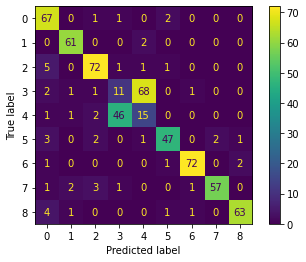

In [30]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# SVM with one vs rest
svm_ovr = OneVsRestClassifier(SVC(C=1000, kernel='linear', probability=True,
                                  class_weight='balanced', random_state=42))
svm_ovr = svm_ovr.fit(X_train_lsi, Y_train)
svm_ovr_pred = svm_ovr.predict(X_test_lsi)

# report
print('\nClassification Report\n')
print(classification_report(Y_test, svm_ovr_pred, target_names=list(labels_dict.keys())))

cm = confusion_matrix(Y_test, svm_ovr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovr.classes_)
disp.plot()
plt.show()

#### Merging class 3 and 4 into new larger label (class 9) and recompute the SVM in One VS One and One VS the rest (both with class balance technique)

In [31]:
# merging class 3 and 4 to class 9
Y_train_rep = Y_train.replace([3, 4], 9)
Y_test_rep = Y_test.replace([3, 4], 9)


Classification Report:
  accuracy: 92.06% 



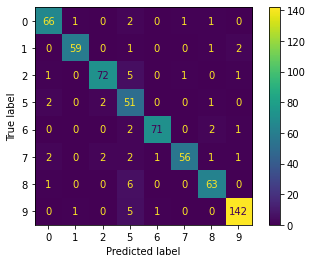

In [32]:
# SVM with one vs one
svm_ovo = OneVsOneClassifier(SVC(C=1000, kernel='linear', probability=True,
                                 class_weight='balanced', random_state=42))
svm_ovo = svm_ovo.fit(X_train_lsi, Y_train_rep)
svm_ovo_pred = svm_ovo.predict(X_test_lsi)

# report
cm = confusion_matrix(Y_test_rep, svm_ovo_pred)
accuracy = np.array([cm[i,i] for i in range(cm.shape[0])]).sum() / cm.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovo.classes_)

print('\nClassification Report:')
print('  accuracy: {:5.2f}% \n'.format(accuracy*100))

disp.plot()
plt.show()


Classification Report:
  accuracy: 92.22% 



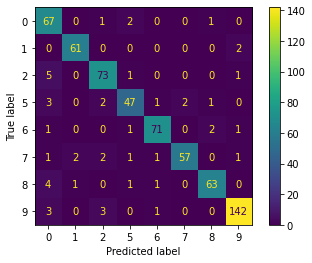

In [33]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# SVM with one vs rest
svm_ovr = OneVsRestClassifier(SVC(C=1000, kernel='linear', probability=True,
                                  class_weight='balanced', random_state=42))
svm_ovr = svm_ovr.fit(X_train_lsi, Y_train_rep)
svm_ovr_pred = svm_ovr.predict(X_test_lsi)

# report
cm = confusion_matrix(Y_test_rep, svm_ovr_pred)
accuracy = np.array([cm[i,i] for i in range(cm.shape[0])]).sum() / cm.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovr.classes_)

print('\nClassification Report:')
print('  accuracy: {:5.2f}% \n'.format(accuracy*100))

disp.plot()
plt.show()

#### Show the class imbalance impact on the performance of both SVM in One VS One and One VS the rest



In [34]:
# merging class 3 and 4 to class 9
Y_train_rep = Y_train.replace([3, 4], 9)
Y_test_rep = Y_test.replace([3, 4], 9)


Classification Report:
  accuracy: 92.06% 



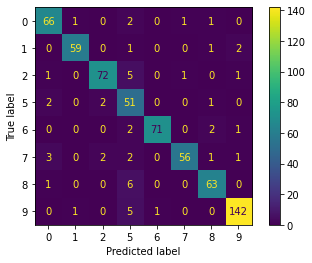

In [35]:
# SVM with one vs one (no class balancing technique)
svm_ovo = OneVsOneClassifier(SVC(C=1000, kernel='linear', probability=True,
                                 class_weight=None, random_state=42))
svm_ovo = svm_ovo.fit(X_train_lsi, Y_train_rep)
svm_ovo_pred = svm_ovo.predict(X_test_lsi)

# report
cm = confusion_matrix(Y_test_rep, svm_ovo_pred)
accuracy = np.array([cm[i,i] for i in range(cm.shape[0])]).sum() / cm.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovo.classes_)

print('\nClassification Report:')
print('  accuracy: {:5.2f}% \n'.format(accuracy*100))

disp.plot()
plt.show()


Classification Report:
  accuracy: 92.06% 



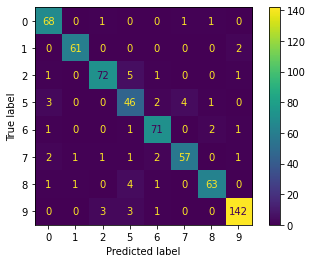

In [36]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# SVM with one vs rest (no class balancing technique)
svm_ovr = OneVsRestClassifier(SVC(C=1000, kernel='linear', probability=True,
                                  class_weight=None, random_state=42))
svm_ovr = svm_ovr.fit(X_train_lsi, Y_train_rep)
svm_ovr_pred = svm_ovr.predict(X_test_lsi)

# report
cm = confusion_matrix(Y_test_rep, svm_ovr_pred)
accuracy = np.array([cm[i,i] for i in range(cm.shape[0])]).sum() / cm.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=svm_ovr.classes_)

print('\nClassification Report:')
print('  accuracy: {:5.2f}% \n'.format(accuracy*100))

disp.plot()
plt.show()

<div class="alert alert-block alert-success">
<b>Question 9:</b> In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.
 
Perform Na¨ıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?
    
<ul>
  <li>In the confusion matrix you should have an 9 × 9 matrix where 9 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:</li>
    <ul> 
 map_row_to_class = {0:"chess", 1:"cricket", 2:"hockey", 3:"soccer", 4:"football", 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake", 8:"drought"}
    </ul>
    Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?
 
 
  <li>Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?
  <li>Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>

All of the experiment results are shown above. To resolve the class imbalance issue in the One VS the rest model, I applied class weight balance to the model, which will automatically adjust weights inversely proportional to class frequencies in the input data.

<ul>
  <li>Based on the result shown above, there are distinctly visible blocks on the major diagonal in both SVM One VS One and One VS rest models. This means that a large portion of the model prediction is correct which corresponds to a high accuracy of 74% for both as shown above. However, in the Na¨ıve Bayes model, instead of on the major diagonal, the distinctly visible blocks are on the fourth column, which is class 3. This means that the Na¨ıve Bayes model tends to falsely predict class 3 as the output. Therefore, the accuracy is relatively low, only 30%.</li>
  <li>Based on the result from the SVM One VS One and One VS rest models, it is reasonable to merge classes 3 and 4 into a larger label, namely class 9, since they are largely confused with each other, leading to lots of wrong predictions and low accuracy. After the merge, the accuracy of the SVM One VS One model raises from 74% to 92.06%, and the accuracy of the SVM One VS rest model raises from 74% to 92.22%.</li>
  <li>For the SVM One VS One model, the class imbalance issue doesn't impact any model performance after the classes are merged. However, the SVM One VS rest model does show a slight performance reduction due to the class imbalance (around 0.2%). The result of the accuracy and the confusion matrix of the SVM One VS One and One VS rest models without class balancing technique is demonstrated above.</li>
</ul>
</div>

## Word Embedding

In [9]:
embeddings_dict = {}
dimension_of_glove = 300
with open("/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt", 'r') as f: # if 'r' fails with unicode
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [10]:
exp = embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']
print('Expected value for Q(c)-1: {}'.format(np.linalg.norm(exp, ord=2)))

Expected value for Q(c)-1: 6.165036678314209


In [11]:
exp = embeddings_dict['queen'] - embeddings_dict['king']
print('Expected value for Q(c)-2: {}'.format(np.linalg.norm(exp, ord=2)))

Expected value for Q(c)-2: 5.9662580490112305


In [12]:
exp = embeddings_dict['wife'] - embeddings_dict['husband']
print('Expected value for Q(c)-2: {}'.format(np.linalg.norm(exp, ord=2)))

Expected value for Q(c)-2: 3.1520464420318604


<div class="alert alert-block alert-success">
<b>Question 10:</b> Read the paper about GLoVE embeddings and answer the following:
<ul>
  <li>(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?</li> 
  <li>(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?</li> 
  <li>(c) What do you expect for the values of,</li> 
    <ul>
      <li>$||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||_2$,</li> 
      <li>$||GLoVE["queen"] - GLoVE["king"]||_2$</li> 
      <li>$||GLoVE["wife"] - GLoVE["husband"]||_2$</li> 
        Compare these values.
    </ul>
  <li>(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding? </li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>
<ul>
  <li>(a) Compared to the raw probabilities, the ratio is better able to distinguish relevant words from irrelevant words and it is also better able to discriminate between the two relevant words.</li>
  <li>(b) GLoVE embeddings will return the same vector in both cases since it is not context-aware and will only generate fixed embeddings based on the mapping.</li>
  <li>(c) Since $||(a-b) - (c-d)||_2 \geq ||(a-b)||_2 - ||(c-d)||_2$ so:</li>
    $||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||_2 $
    $ \space\space \geq ||GLoVE["queen"]−GLoVE["king"]||_2 - ||GLoVE["wife"]−GLoVE["husband"]||_2$
  <li>(d) I would rather lemmatize the word since stemming tries to map multiple word derivatives to the same root word by cutting off some parts. If the stemmed word does not exist in GLoVe embeddings then this word will be assigned a default vector of '0's, which losses it's meaning at all.</li>
</ul>
</div>

Simple concatenation of all of the embeddings of words in that segment will result in a highdimensional
vector representation of varying sizes. Therefore, we need to design a feature
construction procedure to make use of the word embeddings. The goals include:

1. The representation of segments of text of varying lengths – we plotted the histogram
in Question 1 – should be mapped into the same dimension to facilitate downstream
applications;
2. The representation should be a sufficient description of the content of a document, so as
to support the classification.

In [64]:
from sklearn.model_selection import train_test_split
import re

# extract only full_text and leaf_label columns and split into train and test
train, test = train_test_split(dataset[["full_text", "summary", "keywords", "root_label"]], 
                               test_size=0.2)

# clean the full_text
train = train.applymap(clean)
test = test.applymap(clean)

# convert each text to list of words
for row in train.index.values:
    train['full_text'][row] = re.findall(r'\b\S+\b', train['full_text'][row])
    train['summary'][row] = re.findall(r'\b\S+\b', train['summary'][row])
    train['keywords'][row] = re.findall(r'\b\S+\b', train['keywords'][row])
    
for row in test.index.values:
    test['full_text'][row] = re.findall(r'\b\S+\b', test['full_text'][row])
    test['summary'][row] = re.findall(r'\b\S+\b', test['summary'][row])
    test['keywords'][row] = re.findall(r'\b\S+\b', test['keywords'][row])
    
train.head()  

,full_text,summary,keywords,root_label
1563,"[The, Collegian, team, put, their, fortune-tel...","[The, Collegian, team, put, their, fortune-tel...","[2023, season, second, predictions, collegian,...",sports
986,"[The, information, given, to, the, U.S, Soccer...","[They, also, played, together, on, the, 2002, ...","[reynas, soccer, wife, earnie, statement, moth...",sports
2152,"[Legislation, passed, this, week, by, the, Flo...","[And, the, residents, for, the, most, part, ca...","[requirements, flood, homeowners, key, propert...",climate
2016,"[A, new, report, shows, California, utilities,...","[A, new, report, shows, California, utilities,...","[reduced, wildfires, utility, vulnerable, liab...",climate
1682,"[Its, been, two, years, since, weve, been, abl...","[Its, been, two, years, since, weve, been, abl...","[season, elizabeth, crown, prince, historical,...",sports


In [65]:
# convert to GloVe vectors based on sum and mean 
def glove_feature_transform(words):
    embed_vec = 0
    for word in words:
        if word in embeddings_dict.keys():
            embed_vec += embeddings_dict[word]
        else: 
            embed_vec += 0
            
    return embed_vec / len(words)

train['full_text'] = train['full_text'].apply(glove_feature_transform)
train['summary'] = train['summary'].apply(glove_feature_transform)
train['keywords'] = train['keywords'].apply(glove_feature_transform)
test['full_text'] = test['full_text'].apply(glove_feature_transform)
test['summary'] = test['summary'].apply(glove_feature_transform)
test['keywords'] = test['keywords'].apply(glove_feature_transform)

In [66]:
# convert GT class labels to numbers {'climate': 0, 'sports': 1}
labels_dict = dict(zip(train['root_label'].unique(), 
                       range(0,train['root_label'].unique().size)))
Y_train = train['root_label'].map(labels_dict, na_action='ignore')
Y_test = test['root_label'].map(labels_dict, na_action='ignore')

In [67]:
# combine all together by normalizing and then summing each feature vectors 
X_train = np.array(np.array([i / np.linalg.norm(i) for i in train['keywords'].values]) + 
                   np.array([i / np.linalg.norm(i) for i in train['summary'].values]) + 
                   np.array([i / np.linalg.norm(i) for i in train['full_text'].values]))

X_test = np.array(np.array([i / np.linalg.norm(i) for i in test['keywords'].values]) + 
                  np.array([i / np.linalg.norm(i) for i in test['summary'].values]) + 
                  np.array([i / np.linalg.norm(i) for i in test['full_text'].values]))

X_train.shape, X_test.shape

((2520, 300), (630, 300))

- Classification:
    Accuracy: 97.14%
    Precision: 0.9681
    Recall: 0.9681
    F1-score: 0.9681
--------------------
  - Confusion Matrix:
    -----------------------
    | TP:  273 | FP:    9 |
    -----------------------
    | FN:    9 | TN:  339 |
    -----------------------
--------------------


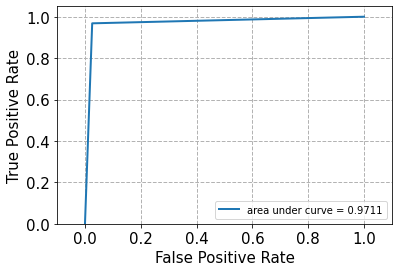

In [76]:
# use SVM model as classifier model

from sklearn.svm import SVC

# SVM
svm = SVC(C=2, kernel='linear', probability=True, random_state=42)
svm = svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)
svm_pred_prob = svm.predict_proba(X_test)[::, 1]
# evaluate
fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_pred, pos_label=1)
cm = standard_confusion_matrix(Y_test, svm_pred)
accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_pred)

svm_glove300_acc = accuracy

# report
print_scores(accuracy, precision, recall, f1_score)
print('-' * 20)
print_cm(cm)
print('-' * 20)
plot_roc(fpr, tpr)

<div class="alert alert-block alert-success">
<b>Question 11:</b> For the binary classification task distinguishing the “sports” class and “climate” class:
<ul>
  <li>(a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document. <b>You have to abide by the following rules:</b></li>
    <ul>
      <li>A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.  </li>
      <li>You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.</li>
      <li><b>Important:</b> In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not.</li>
      <li>To aggregate these words into a single vector consider normalization the vectors, averaging across the vectors.</li>
    </ul>
  <li>(b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.  </li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> 
<ul>
  <li>(a) The feature engineering process: Three features are extracted from the dataset to train the model, namely "full_text", "summary", and "keywords". To convert textual data to computer-understandable numeric data, the pre-trained GLoVe model is applied to map each word in a text of each feature to a GLoVE word embedding. These embeddings are then summed together to form a single representation vector for that particular feature, without any normalization of each word vector here as I would like to preserve the hidden information of all word vectors that correspond to the meaning of their original words. After that, to avoid any weight bias toward any feature and keep the dimension of the embedding, normalization is performed on each feature representation vector and these normalized vectors are then added together to generate the final single vector which represents that whole text. </li>
  <li>(b) SVM with $\gamma=2$ is selected here since it yields the best performance after several experiments. The result as well as the classification scores are all shown above. </li>
</ul>
</div>

### Load different pre-trained GLoVE embedding with different dimension [50, 100, 200]

In [147]:
from sklearn.model_selection import train_test_split
import re

# extract only full_text and leaf_label columns and split into train and test
train, test = train_test_split(dataset[["full_text", "summary", "keywords", "root_label"]], 
                               test_size=0.2)

# clean the full_text
train = train.applymap(clean)
test = test.applymap(clean)

# convert each text to list of words
for row in train.index.values:
    train['full_text'][row] = re.findall(r'\b\S+\b', train['full_text'][row])
    train['summary'][row] = re.findall(r'\b\S+\b', train['summary'][row])
    train['keywords'][row] = re.findall(r'\b\S+\b', train['keywords'][row])
    
for row in test.index.values:
    test['full_text'][row] = re.findall(r'\b\S+\b', test['full_text'][row])
    test['summary'][row] = re.findall(r'\b\S+\b', test['summary'][row])
    test['keywords'][row] = re.findall(r'\b\S+\b', test['keywords'][row])

In [148]:
def glove_embedding_classifier(train, test, glove_file):

    # read GLoVe_50d file
    embeddings_dict = {}
    with open(glove_file, 'r') as f: # if 'r' fails with unicode
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    # function to convert to GloVe vectors based on sum and mean 
    def glove_feature_transform(words):
        embed_vec = 0
        for word in words:
            if word in embeddings_dict.keys():
                embed_vec += embeddings_dict[word]
            else: 
                embed_vec += 0
                
        return embed_vec / len(words)

    # convert to GloVe vectors
    train_glove50_text = train['full_text'].apply(glove_feature_transform)
    train_glove50_sum = train['summary'].apply(glove_feature_transform)
    train_glove50_key = train['keywords'].apply(glove_feature_transform)
    test_glove50_text = test['full_text'].apply(glove_feature_transform)
    test_glove50_sum = test['summary'].apply(glove_feature_transform)
    test_glove50_key  = test['keywords'].apply(glove_feature_transform)

    # convert GT class labels to numbers {'climate': 0, 'sports': 1}
    labels_dict = dict(zip(train['root_label'].unique(), 
                           range(0,train['root_label'].unique().size)))
    Y_train = train['root_label'].map(labels_dict, na_action='ignore')
    Y_test = test['root_label'].map(labels_dict, na_action='ignore')

    # combine all together by normalizing and then summing each feature vectors 
    X_train = np.array(np.array([i / np.linalg.norm(i) for i in train_glove50_text.values]) + 
                      np.array([i / np.linalg.norm(i) for i in train_glove50_sum.values]) + 
                      np.array([i / np.linalg.norm(i) for i in train_glove50_key.values]))

    X_test = np.array(np.array([i / np.linalg.norm(i) for i in test_glove50_text.values]) + 
                      np.array([i / np.linalg.norm(i) for i in test_glove50_sum.values]) + 
                      np.array([i / np.linalg.norm(i) for i in test_glove50_key.values]))
    
    # normalize the final vector of each text (each row)
    X_train = X_train / np.linalg.norm(X_train, axis=1)[:, np.newaxis]
    X_test = X_test / np.linalg.norm(X_test, axis=1)[:, np.newaxis]

    # SVM
    svm = SVC(C=2, kernel='linear', probability=True, random_state=42)
    svm = svm.fit(X_train, Y_train)
    svm_pred = svm.predict(X_test)
    svm_pred_prob = svm.predict_proba(X_test)[::, 1]
    # evaluate
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, svm_pred, pos_label=1)
    cm = standard_confusion_matrix(Y_test, svm_pred)
    accuracy, precision, recall, f1_score = evaluation_scores(Y_test, svm_pred)

    # # report
    # print_scores(accuracy, precision, recall, f1_score)
    # print('-' * 20)
    # print_cm(cm)
    # print('-' * 20)
    # plot_roc(fpr, tpr)

    return accuracy

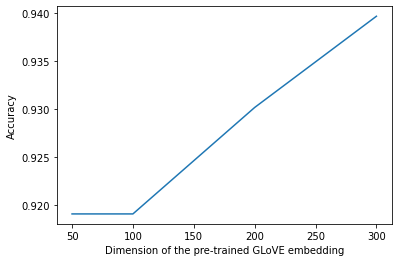

In [149]:
glove50_file = "/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.50d.txt"
glove100_file = "/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.100d.txt"
glove200_file = "/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.200d.txt"
glove300_file = "/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt"

glove_files = [glove50_file, glove100_file, glove200_file, glove300_file]
glove_dim = [50, 100, 200, 300]
accuracies = []

for glove_file in glove_files:
    accuracies.append(glove_embedding_classifier(train, test, glove_file))

plt.plot(glove_dim, accuracies)
plt.xlabel("Dimension of the pre-trained GLoVE embedding")
plt.ylabel("Accuracy")
plt.show()

<div class="alert alert-block alert-success">
<b>Question 12:</b> Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> As illustrated in the plot above, there is an increasing trend of accuracy as the dimension of the pre-trained GLoVE embedding increases. This is to be expected since the higher the feature dimension is, the higher representation as well as the more information the final converted vector can preserve, leading to a more informative data to train the model and thus higher accuracy. 
</div>

Visualize the set of normalized GLoVE-based embeddings of the documents with their binary labels in a 2D plane using the UMAP library. Similarly generate a set of normalized random vectors of the same dimension as GLoVE and visualize these in a 2D plane with UMAP.

In [150]:
# read GLoVe_50d file
embeddings_dict = {}
with open("/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt", 'r') as f: # if 'r' fails with unicode
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# function to convert to GloVe vectors based on sum and mean 
def glove_feature_transform(words):
    embed_vec = 0
    for word in words:
        if word in embeddings_dict.keys():
            embed_vec += embeddings_dict[word]
        else: 
            embed_vec += 0
            
    return embed_vec / len(words)

# convert to GloVe vectors
train_glove50_text = train['full_text'].apply(glove_feature_transform)
train_glove50_sum = train['summary'].apply(glove_feature_transform)
train_glove50_key = train['keywords'].apply(glove_feature_transform)
test_glove50_text = test['full_text'].apply(glove_feature_transform)
test_glove50_sum = test['summary'].apply(glove_feature_transform)
test_glove50_key  = test['keywords'].apply(glove_feature_transform)

# combine all together by normalizing and then summing each feature vectors 
X_train = np.array(np.array([i / np.linalg.norm(i) for i in train_glove50_text.values]) + 
                   np.array([i / np.linalg.norm(i) for i in train_glove50_sum.values]) + 
                   np.array([i / np.linalg.norm(i) for i in train_glove50_key.values]))

X_test = np.array(np.array([i / np.linalg.norm(i) for i in test_glove50_text.values]) + 
                  np.array([i / np.linalg.norm(i) for i in test_glove50_sum.values]) + 
                  np.array([i / np.linalg.norm(i) for i in test_glove50_key.values]))

# normalize the final vector of each text (each row)
X_train = X_train / np.linalg.norm(X_train, axis=1)[:, np.newaxis]
X_test = X_test / np.linalg.norm(X_test, axis=1)[:, np.newaxis]

In [151]:
# !pip install umap-learn

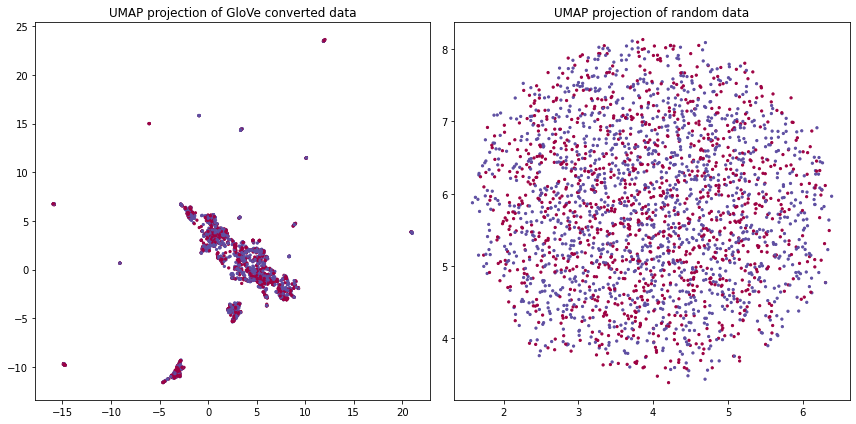

In [152]:
import umap

# apply UMAP to our data
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_train)

# apply UMAP to random vectors
rand_norm_vector = np.random.standard_normal(size=X_train.shape)
reducer_norm = umap.UMAP(random_state=42)
embedding_norm = reducer_norm.fit_transform(rand_norm_vector)

# plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].scatter(reducer.embedding_[:, 0], 
                reducer.embedding_[:, 1], 
                s=5, c=Y_train, cmap='Spectral')
axes[0].set_title('UMAP projection of GloVe converted data', fontsize=12)

axes[1].scatter(reducer_norm.embedding_[:, 0], 
                reducer_norm.embedding_[:, 1], 
                s=5, c=Y_train, cmap='Spectral')
axes[1].set_title('UMAP projection of random data', fontsize=12)

fig.tight_layout()

<div class="alert alert-block alert-success">
<b>Question 13:</b> Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b> Based on the experiment result shown above, there isn't any cluster formed in both of the plots.
</div>